In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path
import pandas as pd
import numpy as np

from datetime import datetime
import os

from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical  # for one-hot encoding (optional)
from tensorflow.keras.utils import Sequence
import cv2
import random

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7916459650115974035
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5733613568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1899689930997315687
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
fold_num = 1

# Image size
img_width, img_height, img_depth = 224, 224, 3
data_dir = r'C:\Users\alway\Downloads\dogs-vs-cats\train'
test_dir = r'C:\Users\alway\Downloads\dogs-vs-cats\test1'


# Load the dataset and split it into train and validation sets
all_images = os.listdir(data_dir)
cat_images = [img for img in all_images if 'cat' in img]
dog_images = [img for img in all_images if 'dog' in img]

# Create dataframe for ease of use
data = pd.DataFrame({
    'Image': cat_images + dog_images,
    'Class': ['cat'] * len(cat_images) + ['dog'] * len(dog_images)
})

# Shuffle and split dataset
df_train, df_valid = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

# Determine number of unique classes dynamically
class_names = np.unique(data['Class'])
num_classes = len(class_names)
batch_size = 32
train_valid_split = 0.2

# Training parameters
epochs = 100
freq = 20
nb_train_samples = int(len(df_train) * (1-train_valid_split))
nb_valid_samples = len(df_train) - nb_train_samples

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for balancing dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data['Class']),
    y=data['Class']
)
class_weights_dict = dict(enumerate(class_weights))

# Class mode for binary classification
if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'

print('Type of classification: ', class_mode)
print('Loss function: ', loss_fun)
print('Activation function: ', act_type)
print('Class weights: ', class_weights_dict)

Type of classification:  categorical
Loss function:  categorical_crossentropy
Activation function:  softmax
Class weights:  {0: 1.0, 1: 1.0}


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


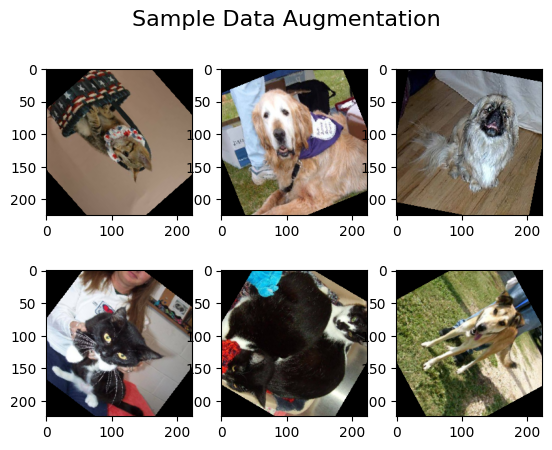

y Labels:  [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
sample img, max value:  1.0
sample img, min value:  0.0


In [3]:

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    fill_mode = 'constant')

# Train and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = data_dir,
    target_size = (img_width, img_height),
    x_col = 'Image',
    y_col = 'Class',
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)

valid_generator = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = data_dir,
    target_size = (img_width, img_height),
    x_col = 'Image',
    y_col = 'Class',
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)

# Preview the augmented data
X_preview, y_preview = train_generator.next()

for k in range(1, 7):
    sample_img = X_preview[k, :, :, :]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize=16)    
plt.show()

print('y Labels: ', y_preview[1:5])
print('sample img, max value: ', np.max(sample_img))
print('sample img, min value: ', np.min(sample_img))

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import applications

# Build VGG16
image_input = Input(shape=(img_width, img_height, img_depth))
base_model = applications.vgg16.VGG16(input_tensor=image_input,
                         include_top=False,
                         weights='imagenet') 

base_output = base_model.output

# Custom layers
# BatchNormalization applied after the base model
batch1 = BatchNormalization(axis=1)(base_output)  # Correct axis for BatchNorm
flat1 = Flatten()(batch1)
fc1 = Dense(4096, activation='relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
batch2 = BatchNormalization(axis=-1)(dropfc1)  # Ensure correct axis for your backend (TensorFlow uses -1)
fc2 = Dense(4096, activation='relu')(batch2)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(num_classes, activation=act_type)(dropfc2)

for layer in base_model.layers[:-9]:
    layer.trainable = False

# Define the model
model = Model(inputs=image_input, outputs=output)

# Check the number of parameters
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

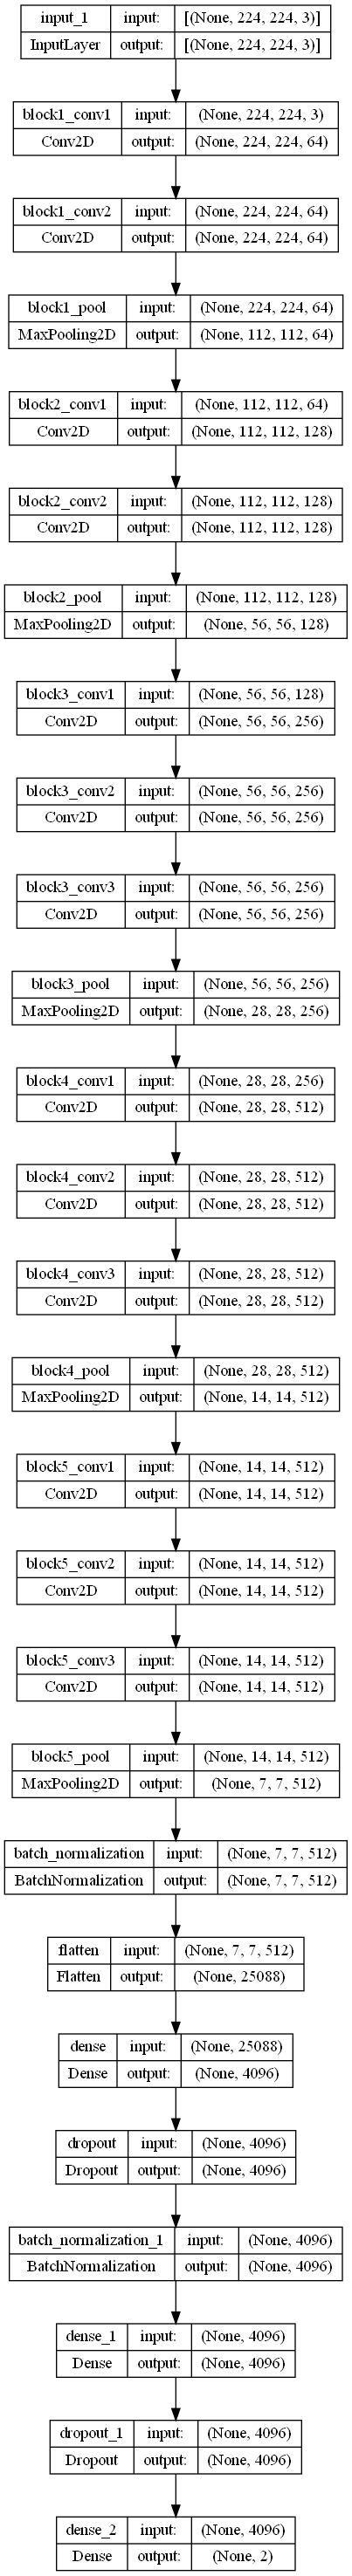

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# Initialize time and directory path
init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = r'.\models\trained_models_' + current_time + '_fold_num' + str(fold_num)

# Create the directory, including intermediate directories if necessary
os.makedirs(name_dir, exist_ok=True)

# Callbacks1: ModelCheckpointer - save only if validation loss improves, every 10 epochs
model_file_format = os.path.join(name_dir, 'model_' + str(fold_num) + '_best_model.{epoch:04d}.hdf5')
check = ModelCheckpoint(model_file_format, monitor='val_acc', save_best_only=True, save_freq='epoch', verbose=1)

# Callbacks2: TensorBoard
tensor_check = os.path.join(r'./logs/', current_time + '_train_testsplit' + str(fold_num))
tensor_board = TensorBoard(log_dir=tensor_check, write_graph=True)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

# Plot model
figure_name = os.path.join(name_dir, 'model_output.png')
plot_model(model, figure_name, show_shapes=True)

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Compile model
opt = Adam(learning_rate=0.001)
model.compile(loss=loss_fun, optimizer=opt, metrics=['accuracy'])

# Define learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Train model with learning rate scheduler, only saving model every 10 epochs if it improves
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=nb_train_samples // batch_size,
                    validation_data=valid_generator,
                    validation_steps=nb_valid_samples // batch_size,
                    callbacks=[check, tensor_board, reduce_lr, early_stop],
                    class_weight=class_weights_dict)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)

Epoch 1/100
500/500 [==============================] - 332s 632ms/step - loss: 0.7692 - accuracy: 0.6909 - val_loss: 0.8986 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 275s 549ms/step - loss: 0.4211 - accuracy: 0.8186 - val_loss: 0.4677 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 181s 361ms/step - loss: 0.3713 - accuracy: 0.8470 - val_loss: 0.3659 - val_accuracy: 0.8515 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 299s 598ms/step - loss: 0.3524 - accuracy: 0.8560 - val_loss: 0.7294 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 222s 444ms/step - loss: 0.3218 - accuracy: 0.8694 - val_loss: 0.3529 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - 171s 342ms/step - loss: 0.3168 - accuracy: 0.8730 - val_loss: 0.3441 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 7/100
500/500 [===================

1/1 [==============================] - 0s 72ms/step


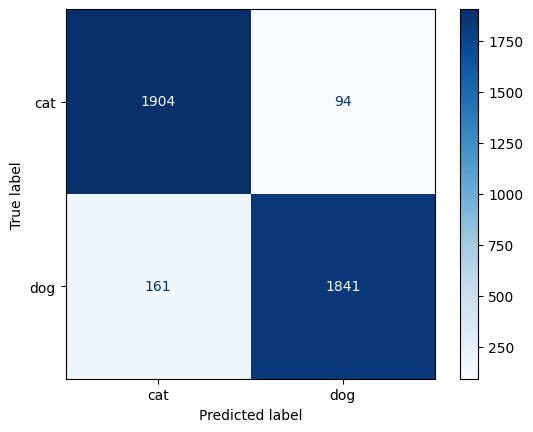

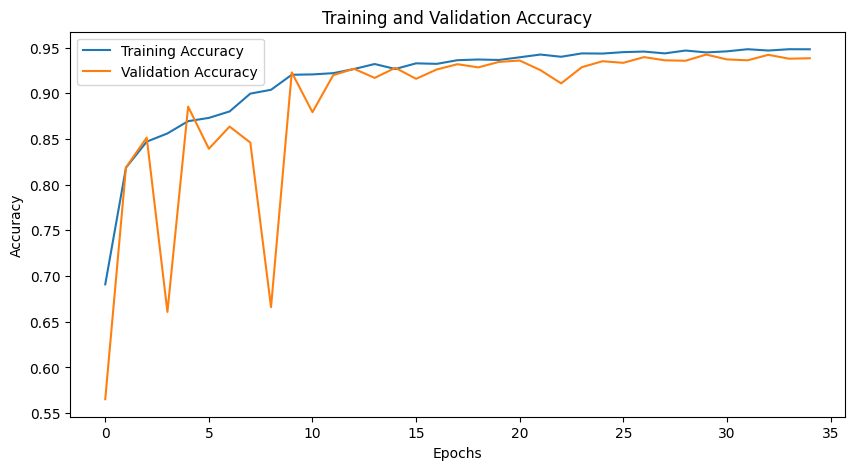

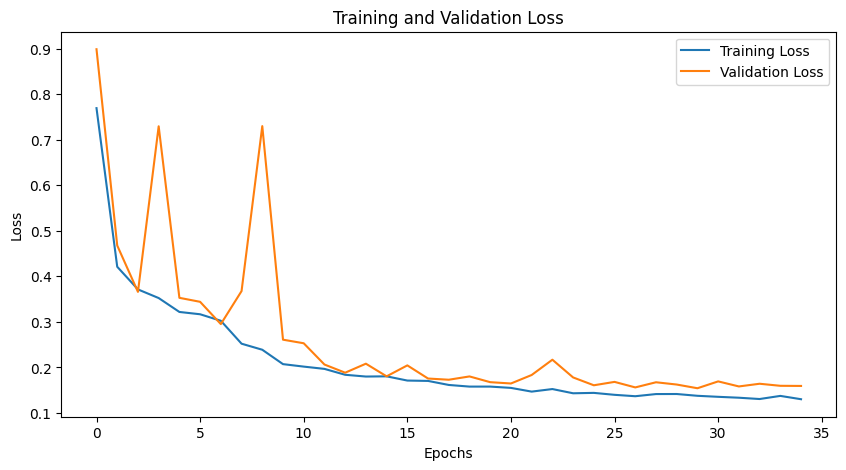

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get validation data and corresponding labels from valid_generator
valid_steps = nb_valid_samples // batch_size

y_true = []
y_pred = []

# Iterate through the validation data
for i in range(valid_steps):
    X_val, y_val = next(valid_generator)
    y_true.append(np.argmax(y_val, axis=1))
    predictions = model.predict(X_val)
    y_pred.append(np.argmax(predictions, axis=1))

# Convert lists to arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [8]:
# Custom ImageLoader that ensures all images are 224x224x3
class ImageLoader(Sequence):
    def __init__(self, dataframe, directory, target_size, batch_size, label_mapping, shuffle=True, num_classes=None, augment=False):
        self.dataframe = dataframe
        self.directory = directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.label_mapping = label_mapping  # Dictionary mapping label strings to integers
        self.shuffle = shuffle
        self.indices = list(range(len(self.dataframe)))
        self.num_classes = num_classes  # If using one-hot encoding
        self.augment = augment  # Flag to apply augmentations
        if self.shuffle:
            random.shuffle(self.indices)
    
    def __len__(self):
        return len(self.dataframe) // self.batch_size
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = os.path.join(self.directory, self.dataframe.iloc[i]['Image'])
            label = self.dataframe.iloc[i]['Class']
            
            # Map the label to its corresponding integer value
            label = self.label_mapping[label]

            # Load the image and resize to target size (224, 224)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (self.target_size[1], self.target_size[0]))  # Resize to target size (224, 224)

            # Normalize the image
            img = img.astype(np.float32) / 255.0

            # Check and ensure that the image has 3 channels (RGB)
            if img.shape[-1] != 3:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB if necessary

            # Apply augmentations if enabled
            if self.augment:
                img = self.apply_augmentations(img)

            # Ensure the image is resized back to target size after augmentations
            img = cv2.resize(img, (self.target_size[1], self.target_size[0]))

            # Convert label to a scalar or one-hot encoded format
            if self.num_classes:
                # One-hot encoding for categorical labels
                label = to_categorical(label, num_classes=self.num_classes)
            else:
                label = np.array([label])  # For binary classification, wrap scalar labels in an array

            batch_images.append(img)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.indices)

    def apply_augmentations(self, img):
        # Random rotation
        if random.random() < 0.5:
            angle = random.randint(-30, 30)
            M = cv2.getRotationMatrix2D((self.target_size[1] // 2, self.target_size[0] // 2), angle, 1)
            img = cv2.warpAffine(img, M, (self.target_size[1], self.target_size[0]))

        # Random horizontal flip
        if random.random() < 0.5:
            img = cv2.flip(img, 1)

        # Random zoom
        if random.random() < 0.5:
            scale = random.uniform(0.8, 1.2)
            h, w = img.shape[:2]
            new_h, new_w = int(h * scale), int(w * scale)
            img = cv2.resize(img, (new_w, new_h))
            img = img[(new_h - h) // 2:(new_h + h) // 2, (new_w - w) // 2:(new_w + w) // 2]

        # Random brightness adjustment
        if random.random() < 0.5:
            value = random.uniform(0.8, 1.2)
            img = np.clip(img * value, 0, 1)

        return img

In [9]:
label_mapping = {'dog': 0, 'cat': 1}  # Mapping labels to integers
num_classes = len(label_mapping)  # Number of classes

train_loader = ImageLoader(df_train, data_dir, target_size=(img_width, img_height), batch_size=batch_size, label_mapping=label_mapping, num_classes=num_classes, augment=True)
valid_loader = ImageLoader(df_valid, data_dir, target_size=(img_width, img_height), batch_size=batch_size, label_mapping=label_mapping, num_classes=num_classes)


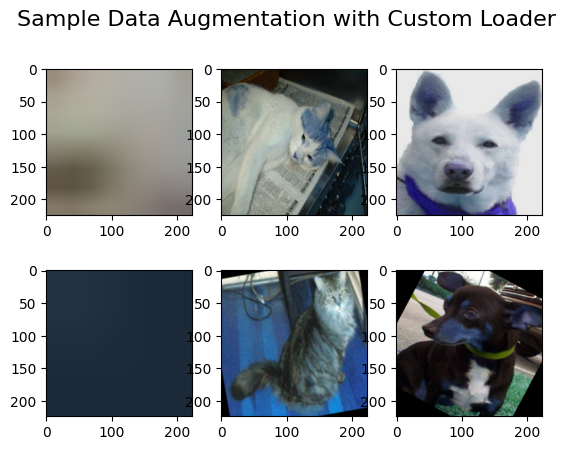

y Labels (first 5):  [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Sample img, max value:  1.0
Sample img, min value:  0.0


In [10]:
# Preview augmented data
X_preview, y_preview = train_loader.__getitem__(0)

# Debugging output
for k in range(1, 7):
    sample_img = X_preview[k, :, :, :]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation with Custom Loader', fontsize=16)    
plt.show()

print('y Labels (first 5): ', y_preview[1:5])
print('Sample img, max value: ', np.max(sample_img))
print('Sample img, min value: ', np.min(sample_img))


In [12]:
# Train model with learning rate scheduler, only saving model every 10 epochs if it improves
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=nb_train_samples // batch_size,
                    validation_data=valid_generator,
                    validation_steps=nb_valid_samples // batch_size,
                    callbacks=[check, tensor_board, reduce_lr,early_stop],
                    class_weight=class_weights_dict)

early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)

Epoch 1/100
  9/500 [..............................] - ETA: 1:39 - loss: 0.1175 - accuracy: 0.9583

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get validation data and corresponding labels from valid_generator
valid_steps = nb_valid_samples // batch_size

y_true = []
y_pred = []

# Iterate through the validation data
for i in range(valid_steps):
    X_val, y_val = next(valid_generator)
    y_true.append(np.argmax(y_val, axis=1))
    predictions = model.predict(X_val)
    y_pred.append(np.argmax(predictions, axis=1))

# Convert lists to arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

